# Motivation

This section will cover the motivation and idea behind choosing the topic of overfishing and explain which datasets are used and why.


## Problem statement (Goal for end user)

People are already aware of the general story on overfishing, even Netflix has jumped the bandwagon and produced documentaries such as _Seaspiracy_. However, such documentaries seem to mislead the audience [ref](https://www.theguardian.com/environment/2021/mar/31/seaspiracy-netflix-documentary-accused-of-misrepresentation-by-participants) due to over-dramatization. Moreover, most people think of fish as bad for the environment and our world sustainability goals, so they tend to avoid them all together, for example by becoming a vegetarian or vegan.


> What we aim to show, is a sound and objective analysis of unsustainable fishing activities. Providing insights into the best and worst ways of the fishing industry by analysing two particularly interesting countries: China and Norway. Finally, using our analysis, we discuss whether eating fish is a viable option for steady protein supply.



## Datasets

In terms of datasets, we use a wide variety of different datasets to compose our story.

### FAO

The **main** source of data is from _Food and Agriculture Organization of the United Nations_ at the url [https://www.fao.org/home/en](https://www.fao.org/home/en). The organization provides access to a massive database with anything related to food and agricultural data in the world.
Our requirements for the dataset was to have data for most countries (and further on, only Norway and China), some temporal information (years) and come from a credible source.
This yielded the datasets from FAO:

- Fishing industry (import, export, supply, production)
- Fish and seafood consumption per capita
- Sources of consumed protein
- Fishing methods

### Additional sources

Another source of data was the world bank [https://datacatalog.worldbank.org/search/dataset/0037712](https://datacatalog.worldbank.org/search/dataset/0037712)
This gave access to the trend and development of open-ocean fishing versus aquacultural fishing.

Additionally, we were able to get information on the GHG (Greenhouse Gas) emission of aquacultural fishing from [https://www.nature.com/articles/s41586-021-03889-2](https://www.nature.com/articles/s41586-021-03889-2)
### Descriptive data

Finally, we also made use of other third-party datasets that made it easier for us to gather information on a country's GDP and population each year.

In order to join this descriptive data with the main datasets, we had to find a common connection between them. Going by just the country name is risky as some countries go by more than one name and others simply have different spellings. Therefore, we used the country ISO-3 code that is _the_ standard for identifying countries. By merging this mapping onto any dataset using the country name (and making a few manual changes). We were able to get an ISO-3 standardized country code for each dataset that needed to be merged with other data.

Another addition to the descriptive data is the use of a **geojson** file that is used for the choropleth maps. However, the original file was too complex (too many polygons) and therefore took a lot of time to plot and render. We therefore decided to simplify the geojson using an online tool such that we ensure that we maintain interpretability and a high enough resolution for the polygons to overlap correctly with the country borders.

## Why did we choose these datasets

Choosing datasets for this project was not easy as it's difficult to find data that covers information on specific fishing related topics such as fishing gear, emission of aquacultural fish, protein supply for each country and so on. Even more so, it was painful to find data with a temporal aspect over multiple years. This resulted in us fetching data from many different sources after searching through a large amount of infeasible datasets.

We find that the selected datasets are useful because they are a combination of being rich in information (covers many metrics over many countries with few NaN values), covering multiple years of data, cover extremely niche or rare data.

The combination of the datasets provide us with an opportunity to explore overfishing on a global scope as well as diving into the specific methods of China and Norway. Moreover, they also contain information on eating habits in terms of protein supply which helps in analysing both the behaviour of the population and the demand of fish.

# Basic Stats

This section will cover the steps we took in terms of processing the data. Much of the code will be from snippets of the functions in `plots/data`. For brevity's sake, we will try to summarize the key points (across datasets) instead of going into extreme detail for each of the 11 different datasets.

## Choices in data cleaning and preprocessing



### Creating a common key across datasets

As mentioned previously, since we use many different datasets. It's important to have a common key when joining the data together on both countries and year.

For this reason we used the `country_code_map.csv` file.

In [133]:
import pandas as pd

In [134]:
pd.read_csv('data/country_code_map.csv').head(2)

,Country,Alpha-2 code,Alpha-3 code,Numeric code,Latitude (average),Longitude (average)
0,Afghanistan,"""AF""","""AFG""","""4""","""33""","""65"""
1,Albania,"""AL""","""ALB""","""8""","""41""","""20"""


Using the `Country` and the `Alpha-3 Code` (ISO-3) we are able to map country names to country codes. We usually make use of the function below to retrieve the data.

In [135]:
# Defining the country code map. For this case, we over-comment the code for the purpose of the explainer notebook.
def get_country_code_map():
    """
    Retrieve the mapping between country names to country codes and vice versa

    """
    # Select only the relevant columns
    country_code_map = pd.read_csv('data/country_code_map.csv')[['Country', 'Alpha-3 code']]

    # Remove double quotes from the code
    country_code_map['Alpha-3 code'] = country_code_map['Alpha-3 code'].apply(lambda x: x.split('"')[1])

    # Set country as index and convert to dictionary in form of [index] -> [{column: value}]
    country_code_map = country_code_map.set_index('Country').to_dict(orient='index')

    # Reverse dictionary
    country_code_to_country = {value['Alpha-3 code']: key for key, value in country_code_map.items()}
    return country_code_map, country_code_to_country


country_code_map, country_code_to_country = get_country_code_map()
print(f"Country to code map 'Denmark': {country_code_map['Denmark']}")
print(f"Map to country map 'DNK': {country_code_to_country['DNK']}")

Country to code map 'Denmark': {'Alpha-3 code': 'DNK'}
Map to country map 'DNK': Denmark


After retrieving the mapping, we add the keys to the dataset. Some datasets have only country names but no codes, and others the otherway around. For the datasets with only country names, we had to manually map some of the country names to the equivalent name in the mapping dictionary. An example of such is seen below. We will comment the special cases but not more than once.

In [136]:
def get_industry_data():
    df = pd.read_csv('data/FAOSTAT_country_supply_production_import_export.csv')
    df.loc[df['Area'] == "China, mainland", 'Area'] = 'China'  # Generalize to China
    df.loc[df['Area'] == 'China, Hong Kong SAR', 'Area'] = 'China'
    df.loc[df['Area'] == 'China, Macao SAR', 'Area'] = 'China'
    df.loc[df['Area'] == "China, Taiwan Province of", 'Area'] = 'Taiwan'  # Taiwan on it's own
    df.loc[df['Area'] == "C?te d'Ivoire", 'Area'] = "Côte d'Ivoire"  # Special characters
    df.loc[df['Area'] == "Netherlands Antilles (former)", 'Area'] = "Netherlands"  # Longer names
    df.loc[df['Area'] == 'Bolivia (Plurinational State of)', 'Area'] = "Bolivia"  # No parenthesis
    df.loc[df['Area'] == 'Cabo Verde', 'Area'] = "Cape Verde"  # Different names for one country
    df.loc[df['Area'] == 'Czechia', 'Area'] = "Czech Republic"
    df.loc[df['Area'] == "Democratic People's Republic of Korea", 'Area'] = "South Korea"  # Common name rather than formal name
    df.loc[df['Area'] == 'Democratic Republic of the Congo', 'Area'] = "Congo"
    df.loc[df['Area'] == 'Eswatini', 'Area'] = "Swaziland"
    df.loc[df['Area'] == 'Iran (Islamic Republic of)', 'Area'] = "Iran, Islamic Republic of"
    df.loc[df['Area'] == 'North Macedonia', 'Area'] = "Macedonia, the former Yugoslav Republic of"
    df.loc[df['Area'] == 'Republic of Korea', 'Area'] = "Korea, Republic of"  # Reverse naming. Country name before title: country, title
    df.loc[df['Area'] == 'United Kingdom of Great Britain and Northern Ireland', 'Area'] = "United Kingdom"
    df.loc[df['Area'] == 'Republic of Moldova', 'Area'] = "Moldova, Republic of"
    df.loc[df['Area'] == 'United Republic of Tanzania', 'Area'] = "Tanzania, United Republic of"
    df.loc[df['Area'] == 'United States of America', 'Area'] = 'United States'
    df.loc[df['Area'] == 'Venezuela (Bolivarian Republic of)', 'Area'] = 'Venezuela, Bolivarian Republic of'

    # df = add_population(df)   # Out commented for explainer-notebook purposes
    return df

### Adding population data

After finding common keys across datasets, we add the population data for a given year which enables us to calculate any metric per capita: $metric\_per\_capita = \frac{metric}{population}$

In [137]:
def get_population():
    return pd.read_csv('data/population_total.csv')

In [138]:
def add_population(df, country_col='Area'):
    # Get data
    df_population = get_population()
    country_code_map, country_code_to_country = get_country_code_map()

    # Add the country code if it's not present in the dataframe
    if 'Country Code' not in df.columns:
        df['Country Code'] = df.apply(lambda x: country_code_map[x[country_col]]['Alpha-3 code'], axis=1)

    # Kind of advanced data wrangling operation, inspired from the Tidy data paradigm.
    # We give a brief introduction, but please look up the proper documentation if you don't understand the function.
    # Melting a dataframe is useful when we have a variable, such as 'Year' expanded over multiple columns.
    # For example the columns in a dataframe could be: [Country Name, Country Code, 2010, 2011, 2012, ... 2022]
    # Where each value in the 'Year' columns is a variable such as 'population'.
    # Melting the dataframe takes all the columns NAMES defined in 'value_vars' and assigns them to a single column
    # with the name: 'var_name' which in this case is 'Year'. Example var_name = pd.Series([2010, 2011, 2012, ..., 2022])
    # The corresponding value in that column is then assigned to another column in 'value_name'. The pairs of
    # [var_name, value_name] are then identical to what was previously in column format, however it is now only in row format.
    melted = pd.melt(df_population, id_vars=['Country Name', 'Country Code'], value_vars=df_population.columns[2:],
                     var_name='Year',
                     value_name='population')

    # Set year as integer to make them joinable
    melted.Year = melted.Year.astype(int)

    # Final merge operatoin
    df = pd.merge(melted, df, on=['Country Code', 'Year'])
    return df

After running the above function, there is a value of population for each country on each year.

In [139]:
df = get_industry_data()
add_population(df, country_col='Area').sample(4).iloc[:, :4]

,Country Name,Country Code,Year,population
55504,Malta,MLT,2019,504062.0
33754,Eswatini,SWZ,2015,1104038.0
28638,Vanuatu,VUT,2014,263888.0
32176,Madagascar,MDG,2015,24234080.0


### Data quality (NaN values and outliers)

#### Missing values
Missing values were investigated for all datasets. However, most of the datasets luckily did not show significant signs of poor quality in terms of NaN values.
In cases where there were NaN values, it was often in context of a visualization such as when plotting the consumption map. However, when plotting the map with NaN values,
it is a benefit as the countries are **kept out** of the map which is the same as dropping that particular row. If we would have imputed the value with for example: 0, it would've been manipulated data and perhaps lead to misinterpretations.

In [140]:
from plots.data import get_consumption

df = get_consumption()
df.drop('TotalC', axis=1, inplace=True)
df[df.isna().any(axis=1)].sample(5)

,country,Code,Year,consumption
1792,Caribbean,NaN,1998,9.77
9137,Southern Africa,NaN,1979,8.54
1782,Caribbean,NaN,1988,13.31
7461,Northern America,NaN,2002,22.79
1790,Caribbean,NaN,1996,9.87


In [141]:
df[df.isna().any(axis=1)].country.unique().tolist()

['Africa',
 'Americas',
 'Asia',
 'Asia, Central',
 'Australia & New Zealand',
 'Belgium-Luxembourg',
 'Caribbean',
 'Central America',
 'Eastern Africa',
 'Eastern Asia',
 'Eastern Europe',
 'Ethiopia PDR',
 'Europe',
 'Europe, Western',
 'European Union',
 'Land Locked Developing Countries',
 'Least Developed Countries',
 'Low Income Food Deficit Countries',
 'Micronesia (region)',
 'Middle Africa',
 'Net Food Importing Developing Countries',
 'Northern Africa',
 'Northern America',
 'Northern Europe',
 'Oceania',
 'Small island developing States',
 'South America',
 'South Eastern Asia',
 'Southern Africa',
 'Southern Asia',
 'Southern Europe',
 'Sudan (former)',
 'Western Africa',
 'Western Asia']

It's seen that there are some countries that have missing country codes, but this is no issue for plotting. Moreover, we use the a custom _geojson_ to plot the maps, meaning that the regions such as (Africa, Americas, Asia, Europe, ...) will be left out as they aren't in the geojson.

In [142]:
import json

with open('data/countries-simplified.json') as response:
    countries = json.load(response)

countries['features'][0]['properties']

{'ADMIN': 'Aruba', 'ISO_A3': 'ABW', 'ISO_A2': 'AW'}

As you can see, we use the ISO_A3 (ISO Alpha 3) code to map countries and the geojson together. The ISO3 codes are in the consumption dataset, but _not_ in the industry dataset, which is why we add the country codes to it using the mapping. As without any country codes, we wouldn't be able to plot a choropleth map of the fishing industry

#### Outliers

Outliers didn't cause much trouble either. Except for one place when working with the scale of the colorbar in the consumption map. Let's take a look at the code. We WONT plot the map here as it takes up 150 Mb in the offline version.

In [143]:
from utils.decorator import style_plot
import plotly.express as px


@style_plot
def plot_consumption_map(df):
    with open('data/countries-simplified.json') as response:
        countries = json.load(response)

    # OUTLIERS!
    range_color = (0, df.consumption.quantile(0.99))
    # OUTLIERS!

    map_args = dict(
        geojson=countries,
        featureidkey='properties.ISO_A3',
        locations="Code",
        color="consumption",  # lifeExp is a column of gapminder
        hover_name="country",  # column to add to hover information
        animation_frame='Year',
        mapbox_style="carto-positron",
        color_continuous_scale='YlOrRd',
        range_color=range_color,
        title='Fish consumption (kg / capita) from 1961 to 2017',
        center={'lat': 12, 'lon': 5}
    )

    fig = px.choropleth_mapbox(df, zoom=0.5, **map_args)
    # More styling code below but it's been left out for brevity's sake.

As seen in line 10 of the cell above, we have adjusted the color of the range from 0 to 99% quantile. This is due to few extreme outliers that make identifying other high-consumption countries difficult. Let's take a look at the outliers.

In [144]:
df = get_consumption()

df.consumption.describe()

count    11028.000000
mean        16.670872
std         17.056281
min          0.000000
25%          5.340000
50%         11.995000
75%         22.512500
max        191.750000
Name: consumption, dtype: float64

The maximum value is 191 whilst the 75% quantile is only 22.5!! The data is clearly skewed.

<AxesSubplot:>

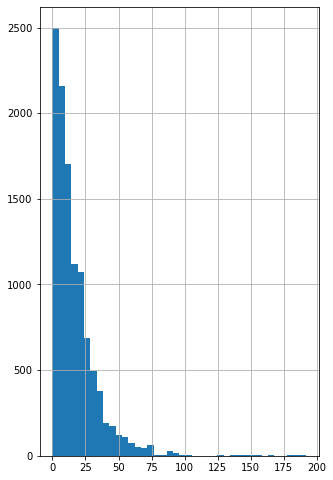

In [145]:
# Very simple plot for illustrative purposes.
df.consumption.hist(bins=40)

<AxesSubplot:>

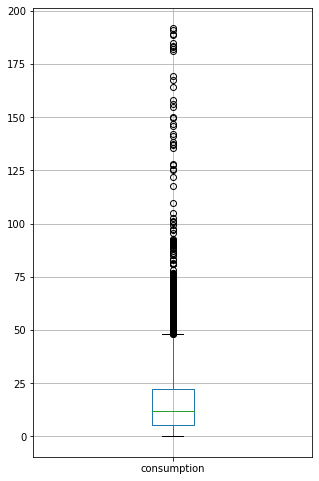

In [146]:
df.boxplot(column='consumption')

The 99% quantile is then

In [147]:
df.consumption.quantile(0.99)

75.34459999999999

Which is MUCH more reasonable when looking at the plots above as well.

**Industry dataset outliers**

We replicated the method above for the Industry dataset (import, export, production and supply) as well, however we don't find the need to replicate the whole process and analysis again (as it's copy paste with different a different dataset).
The resulting relevant quantile for the Industry dataset turned out to be 0.975 due to the same reasons above (extreme outliers).

**Other datasets**

With respect to the other datasets we didn't find any significant outliers that hindered the analysis or visualization.

## Dataset stats and key points

We have already touched upon the outlier and NaN value detection and corresponding mitigation techniques.

Here we will go over some descriptive statistics on our datasets, and present some key points of the exploratory analysis that lead us to the final visualizations found on the website.

Since we are working with multiple datasets, we will focus on the ones that have the highest data quality and information.

### Data summary and Descriptive statistics

In this section we will provide insights and examples from the datasets and
also perform some descriptive statistics.

Generally, we will keep the analysis brief as there are a lot of datasets to cover.
This is the only time we'll be showcasing all 11 datasets.

This section is meant to give the reader a quick overview of what each dataset used in this project contains.

#### Country Code Mappings

In [148]:
country_code_map = pd.read_csv('data/country_code_map.csv')[['Country', 'Alpha-3 code']]
country_code_map.describe()

,Country,Alpha-3 code
count,256,256
unique,256,244
top,Afghanistan,"""VCT"""
freq,1,3


In [149]:
country_code_map.head()

,Country,Alpha-3 code
0,Afghanistan,"""AFG"""
1,Albania,"""ALB"""
2,Algeria,"""DZA"""
3,American Samoa,"""ASM"""
4,Andorra,"""AND"""


In [150]:
country_code_map.Country.unique().tolist()

['Afghanistan',
 'Albania',
 'Algeria',
 'American Samoa',
 'Andorra',
 'Angola',
 'Anguilla',
 'Antarctica',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bermuda',
 'Bhutan',
 'Bolivia, Plurinational State of',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Bouvet Island',
 'Brazil',
 'British Indian Ocean Territory',
 'Brunei Darussalam',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cape Verde',
 'Cayman Islands',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Christmas Island',
 'Cocos (Keeling) Islands',
 'Colombia',
 'Comoros',
 'Congo',
 'Congo, the Democratic Republic of the',
 'Cook Islands',
 'Costa Rica',
 "Côte d'Ivoire",
 'Ivory Coast',
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czech Republic',
 'Denmark',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Ecuador

As we can see, the country code mapping is almost what one would expect. Given the country name there is a corresponding country code.

One interesting thing to look at is the fact that there are `256` unique countries but only `244` unique country codes. Meaning some countries map to the same country code. Let's have a look

In [151]:
country_code_map[country_code_map['Alpha-3 code'].duplicated()]

,Country,Alpha-3 code
26,Bolivia,"""BOL"""
33,Brunei,"""BRN"""
55,Ivory Coast,"""CIV"""
119,South Korea,"""KOR"""
128,Libya,"""LBY"""
155,Burma,"""MMR"""
187,Russia,"""RUS"""
194,Saint Vincent & the Grenadines,"""VCT"""
195,St. Vincent and the Grenadines,"""VCT"""
222,Taiwan,"""TWN"""


In [152]:
country_code_map[country_code_map['Alpha-3 code'] == ' "BOL"']

,Country,Alpha-3 code
25,"Bolivia, Plurinational State of","""BOL"""
26,Bolivia,"""BOL"""


In [153]:
country_code_map[country_code_map['Alpha-3 code'] == ' "MMR"']

,Country,Alpha-3 code
154,Myanmar,"""MMR"""
155,Burma,"""MMR"""


It seems that it is just multiple names for a country that maps to the Alpha-3 code. The case of Bolivia is quite obvious.
The case of Myanmar is not so much. The significant difference in name is due to the country being occupied by the British empire which gave the name _Burma_.
After becoming independent, they decided to change the name to _Myanmar_ for cultural reasons [ref](https://en.wikipedia.org/wiki/Names_of_Myanmar)

#### Population

In [154]:
df_pop = get_population()
df_pop.columns

Index(['Country Name', 'Country Code', '1960', '1961', '1962', '1963', '1964',
       '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973',
       '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982',
       '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991',
       '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000',
       '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009',
       '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018',
       '2019', '2020'],
      dtype='object')

In [155]:
df_pop.describe()

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
count,2.640000e+02,2.640000e+02,2.640000e+02,2.640000e+02,2.640000e+02,2.640000e+02,2.640000e+02,2.640000e+02,2.640000e+02,2.640000e+02,...,2.650000e+02,2.650000e+02,2.650000e+02,2.650000e+02,2.650000e+02,2.650000e+02,2.650000e+02,2.650000e+02,2.650000e+02,2.650000e+02
mean,1.173116e+08,1.188586e+08,1.209679e+08,1.235882e+08,1.262297e+08,1.289366e+08,1.317868e+08,1.346309e+08,1.375436e+08,1.405603e+08,...,2.828664e+08,2.866170e+08,2.904120e+08,2.942198e+08,2.980198e+08,3.018343e+08,3.056619e+08,3.094099e+08,3.130784e+08,3.166573e+08
std,3.705555e+08,3.749081e+08,3.814322e+08,3.899277e+08,3.984666e+08,4.072394e+08,4.165735e+08,4.258523e+08,4.353820e+08,4.452976e+08,...,8.906976e+08,9.017794e+08,9.129557e+08,9.241202e+08,9.352185e+08,9.463293e+08,9.574907e+08,9.683242e+08,9.788601e+08,9.890355e+08
min,2.833000e+03,3.077000e+03,3.367000e+03,3.703000e+03,4.063000e+03,4.460000e+03,4.675000e+03,4.922000e+03,5.194000e+03,5.461000e+03,...,1.006900e+04,1.013600e+04,1.020800e+04,1.028900e+04,1.037400e+04,1.047400e+04,1.057700e+04,1.067800e+04,1.076400e+04,1.083400e+04
25%,5.022802e+05,5.109642e+05,5.206540e+05,5.311622e+05,5.421252e+05,5.533362e+05,5.647475e+05,5.823645e+05,5.981078e+05,6.100030e+05,...,1.562996e+06,1.604981e+06,1.648259e+06,1.692433e+06,1.737207e+06,1.777557e+06,1.791003e+06,1.797085e+06,1.788878e+06,1.775378e+06
50%,3.718330e+06,3.826398e+06,3.929109e+06,4.015834e+06,4.124521e+06,4.242788e+06,4.326013e+06,4.387887e+06,4.474171e+06,4.550402e+06,...,9.461643e+06,9.729254e+06,9.893082e+06,9.866468e+06,1.016003e+07,1.032545e+07,1.030030e+07,1.028382e+07,1.028626e+07,1.035344e+07
75%,2.636053e+07,2.721235e+07,2.808607e+07,2.890669e+07,2.972333e+07,3.055227e+07,3.134845e+07,3.200449e+07,3.244145e+07,3.277149e+07,...,5.937945e+07,5.953972e+07,6.023395e+07,6.078914e+07,6.073058e+07,6.062750e+07,6.053671e+07,6.042176e+07,5.972908e+07,5.973421e+07
max,3.032156e+09,3.071596e+09,3.124561e+09,3.189656e+09,3.255146e+09,3.322047e+09,3.392098e+09,3.461620e+09,3.532783e+09,3.606554e+09,...,7.003760e+09,7.089255e+09,7.175500e+09,7.261847e+09,7.347679e+09,7.433569e+09,7.519183e+09,7.602454e+09,7.683372e+09,7.761620e+09


In [156]:
df_pop[['Country Name', 'Country Code']]

,Country Name,Country Code
0,Aruba,ABW
1,Africa Eastern and Southern,AFE
2,Afghanistan,AFG
3,Africa Western and Central,AFW
4,Angola,AGO
...,...,...
261,Kosovo,XKX
262,"Yemen, Rep.",YEM
263,South Africa,ZAF
264,Zambia,ZMB


As we can see, the population is just the population of a country in a given year. Strangely enough, the year variable is expanded over columns. This gave rise to the data preprocessing detailed above.

#### Industry data

In [157]:
df_industry = pd.read_csv('data/FAOSTAT_country_supply_production_import_export.csv')
df_industry.columns

Index(['Domain Code', 'Domain', 'Area Code (FAO)', 'Area', 'Element Code',
       'Element', 'Item Code', 'Item', 'Year Code', 'Year', 'Unit', 'Value',
       'Flag', 'Flag Description'],
      dtype='object')

In [158]:
df_industry['Element'].unique()

array(['Production', 'Import Quantity', 'Domestic supply quantity',
       'Export Quantity'], dtype=object)

The industry data contains information on the Production, Import Quantity, Domestic supply quantity, and Export Quantity.

The four quantities are related by:

$$
\text{production} + \text{import} = \text{supply} + \text{export}
$$

The Domestric supply quantity is what's left over in the country after exporting

In [159]:
df_industry.describe()

,Area Code (FAO),Element Code,Item Code,Year Code,Year,Value
count,58100.000000,58100.000000,58100.000000,58100.000000,58100.000000,58100.000000
mean,128.613253,5577.241824,2788.507470,2014.505938,2014.505938,201.714659
std,73.994864,221.571138,64.284051,2.871461,2.871461,1842.178378
min,1.000000,5301.000000,2761.000000,2010.000000,2010.000000,0.000000
25%,67.000000,5301.000000,2763.000000,2012.000000,2012.000000,0.090000
50%,123.000000,5611.000000,2765.000000,2015.000000,2015.000000,2.520000
75%,191.000000,5611.000000,2767.000000,2017.000000,2017.000000,34.930000
max,351.000000,5911.000000,2960.000000,2019.000000,2019.000000,67902.890000


Interestingly, the `Value` column seems to have an incredibly large standard deviation (`1842`) wrt the mean (`202`). Let's investigate

<AxesSubplot:>

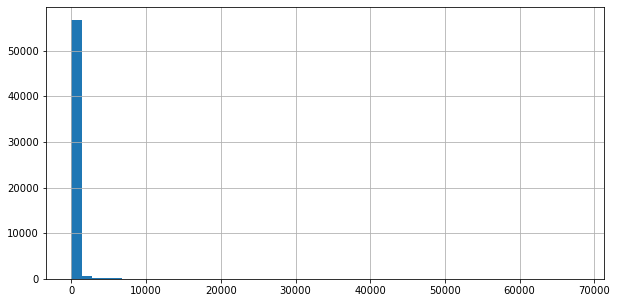

In [160]:
df_industry['Value'].hist(bins=50, figsize=(10, 5))

<AxesSubplot:>

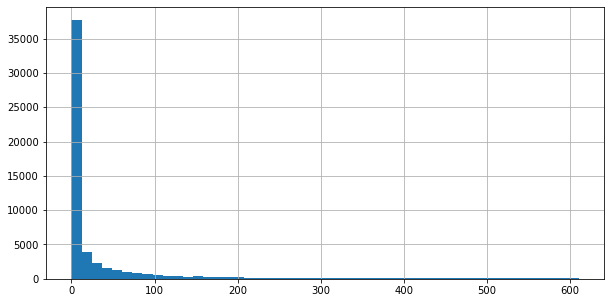

In [161]:
df_industry[df_industry.Value <= df_industry['Value'].quantile(0.95)]['Value'].hist(bins=50, figsize=(10, 5))

As we can see, the value column is extremely skewed, even when only looking at the $95\%$ percentile.

This should be kept in mind if modelling this value as some, for example linear, models assume normal distribution of residuals, which will be difficult in this case for linear regression.

#### Consumption


In [162]:
df_consumption = pd.read_csv("data/fish-and-seafood-consumption-per-capita.csv")
df_consumption.drop('TotalC', axis=1, inplace=True)
df_consumption.columns

Index(['Entity', 'Code', 'Year',
       'Fish, Seafood- Food supply quantity (kg/capita/yr) (FAO, 2020)'],
      dtype='object')

In [163]:
df_consumption.describe()

,Year,"Fish, Seafood- Food supply quantity (kg/capita/yr) (FAO, 2020)"
count,11028.000000,11028.000000
mean,1989.461824,16.670872
std,16.320065,17.056281
min,1961.000000,0.000000
25%,1975.000000,5.340000
50%,1990.000000,11.995000
75%,2004.000000,22.512500
max,2017.000000,191.750000


We have seen this table before and will refer to section on **Basic Stats > Choices in data cleaning and preprocessing > Data quality > Outliers** for a detailed analysis.

#### Sustainability levels

In [164]:
sustainable = pd.read_csv('data/fish-stocks-within-sustainable-levels.csv')
sustainable.columns

Index(['Entity', 'Code', 'Year',
       'Share of fish stocks within biologically sustainable levels (FAO, 2020)',
       'Share of fish stocks that are overexploited'],
      dtype='object')

In [165]:
sustainable.Entity.unique().tolist()

['Eastern Central Atlantic',
 'Eastern Central Pacific',
 'Eastern Indian Ocean',
 'Mediterranean and Black Sea',
 'Northeast Central Atlantic',
 'Northeast Pacific',
 'Northwest Central Atlantic',
 'Northwest Pacific',
 'Southeast Central Atlantic',
 'Southeast Pacific',
 'Southwest Atlantic',
 'Southwest Pacific',
 'Western Central Atlantic',
 'Western Central Pacific',
 'Western Indian Ocean',
 'World']

We see that the unique entities are not countries but regions and the whole world on aggregate.

In [166]:
sustainable.value_counts('Entity')

Entity
World                          21
Eastern Central Atlantic        2
Eastern Central Pacific         2
Eastern Indian Ocean            2
Mediterranean and Black Sea     2
Northeast Central Atlantic      2
Northeast Pacific               2
Northwest Central Atlantic      2
Northwest Pacific               2
Southeast Central Atlantic      2
Southeast Pacific               2
Southwest Atlantic              2
Southwest Pacific               2
Western Central Atlantic        2
Western Central Pacific         2
Western Indian Ocean            2
dtype: int64

However, we only have enough records over the years from the whole world on aggregate and not individual regions.
That is a shame as it would've been an interesting analysis to compare the regions across years.

In [167]:
sustainable.describe()

,Year,"Share of fish stocks within biologically sustainable levels (FAO, 2020)",Share of fish stocks that are overexploited
count,51.000000,51.000000,51.000000
mean,2007.705882,70.521579,29.478421
std,13.150352,13.885635,13.885635
min,1974.000000,37.500000,8.536585
25%,2002.000000,66.257862,18.156843
50%,2015.000000,73.076920,26.923080
75%,2017.000000,81.843157,33.742138
max,2017.000000,91.463415,62.500000


This is a very simple dataset that contains information on fish stocks within biologically sustainable levels and those that are overexploited.
From a statistics point of view, we don't find that the range, mean or standard deviation deviate significantly from each other.

#### Fishing types

In [168]:
fish_catch_methods = pd.read_csv('data/fish-catch-gear-type.csv')
fish_catch_methods.columns

Index(['Entity', 'Code', 'Year', 'unknown_gear', 'other_gear', 'longline',
       'gillnet', 'small_scale', 'purse_seine', 'pelagic trawl',
       'bottom_trawl'],
      dtype='object')

In [169]:
fish_catch_methods.describe()

,Year,unknown_gear,other_gear,longline,gillnet,small_scale,purse_seine,pelagic trawl,bottom_trawl
count,13730.000000,5.888000e+03,1.326200e+04,4.741000e+03,2.644000e+03,1.362100e+04,5.353000e+03,3.207000e+03,6.452000e+03
mean,1983.997524,1.224957e+05,1.045311e+05,6.749434e+04,1.146527e+05,1.591695e+05,6.046160e+05,3.660685e+05,4.955176e+05
std,19.915829,6.486284e+05,7.575254e+05,3.088369e+05,4.306811e+05,1.165515e+06,3.027294e+06,1.504896e+06,2.545924e+06
min,1950.000000,4.777330e-04,2.316511e-03,0.000000e+00,1.878924e-03,3.125000e-02,1.095000e-05,1.536633e-02,4.814493e-02
25%,1967.000000,1.538425e+02,2.142967e+02,2.508726e+02,4.001844e+02,1.215442e+03,3.106388e+03,5.160324e+03,6.600340e+03
50%,1984.000000,2.866114e+03,2.435931e+03,2.299492e+03,4.055886e+03,8.231333e+03,2.967633e+04,5.117854e+04,4.739002e+04
75%,2001.000000,3.130528e+04,2.660862e+04,1.601166e+04,5.109389e+04,4.737938e+04,1.702555e+05,1.885561e+05,2.157852e+05
max,2018.000000,1.067776e+07,1.442334e+07,3.585876e+06,4.326715e+06,2.138083e+07,4.088014e+07,1.658761e+07,3.329230e+07


The dataset contains information on the 'fishing_types' variable in terms of columns that each represent a method of fishing.
The temporal dimension ranges from 1950 to 2018 which gives us a good baseline for plotting historical development.

#### Greenhouse gasses from food sources

In [170]:
gg = pd.read_csv('data/ghg-per-protein-poore.csv')
gg.columns

Index(['Entity', 'Code', 'Year',
       'GHG emissions per 100g protein (Poore & Nemecek, 2018)'],
      dtype='object')

In [171]:
gg.Entity.unique().tolist()

['Apples',
 'Bananas',
 'Beef',
 'Beef (dairy herd)',
 'Berries & Grapes',
 'Brassicas',
 'Cassava',
 'Cheese',
 'Citrus Fruit',
 'Coffee',
 'Dark Chocolate',
 'Eggs',
 'Fish, Seafood',
 'Grains',
 'Groundnuts',
 'Lamb & goat',
 'Maize',
 'Milk',
 'Nuts',
 'Oatmeal',
 'Onions & Leeks',
 'Other Pulses',
 'Peas',
 'Pork',
 'Potatoes',
 'Poultry',
 'Prawns (farmed)',
 'Rice',
 'Root Vegetables',
 'Tofu (soybeans)',
 'Tomatoes',
 'Wheat & Rye']

As we can see, the dataset contains GHG emissions from many sources of food. The emissions are measured per 100g of protein.

In [172]:
gg.describe()

,Code,Year,"GHG emissions per 100g protein (Poore & Nemecek, 2018)"
count,0.0,32.0,32.000000
mean,NaN,2010.0,12.222378
std,NaN,0.0,18.244438
min,NaN,2010.0,0.263319
25%,NaN,2010.0,2.518750
50%,NaN,2010.0,6.122183
75%,NaN,2010.0,14.825000
max,NaN,2010.0,93.300000


Here we see that we only have values for year 2010. Moreover, the ghg emissions seem to vary a lot, which makes sense when you have sources such as _Apples_ and _Beef_ in the same dataset.

#### GDP

In [173]:
df_gdp = pd.read_csv('data/country_gdp.csv')
df_gdp.drop('Unnamed: 66', axis=1, inplace=True)
df_gdp.columns

Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021'],
      dtype='object')

In [174]:
df_gdp.describe()

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
count,1.320000e+02,1.340000e+02,1.370000e+02,1.370000e+02,1.370000e+02,1.480000e+02,1.510000e+02,1.540000e+02,1.590000e+02,1.590000e+02,...,2.570000e+02,2.580000e+02,2.580000e+02,2.570000e+02,2.560000e+02,2.560000e+02,2.560000e+02,2.530000e+02,2.420000e+02,0.0
mean,7.186024e+10,7.266395e+10,7.577239e+10,8.171949e+10,8.975553e+10,9.113823e+10,1.014153e+11,1.052055e+11,1.102810e+11,1.219512e+11,...,2.404985e+12,2.482656e+12,2.553926e+12,2.407636e+12,2.447651e+12,2.621670e+12,2.787111e+12,2.864960e+12,2.892663e+12,NaN
std,2.144733e+11,2.220896e+11,2.359301e+11,2.538169e+11,2.775807e+11,2.915236e+11,3.191881e+11,3.375833e+11,3.595171e+11,3.957017e+11,...,8.162875e+12,8.388884e+12,8.618353e+12,8.171895e+12,8.322936e+12,8.856136e+12,9.425990e+12,9.620595e+12,9.530219e+12,NaN
min,1.201201e+07,1.159201e+07,9.122751e+06,1.084010e+07,1.271247e+07,1.359393e+07,1.446908e+07,1.583518e+07,1.460000e+07,1.585000e+07,...,3.767177e+07,3.750908e+07,3.729061e+07,3.549207e+07,3.654780e+07,4.061925e+07,4.258816e+07,4.727146e+07,4.885555e+07,NaN
25%,5.081293e+08,5.007338e+08,5.317365e+08,5.161478e+08,5.425784e+08,5.863716e+08,6.380995e+08,6.238584e+08,6.440071e+08,6.834820e+08,...,8.709165e+09,8.747774e+09,9.297231e+09,8.738203e+09,8.666853e+09,9.565595e+09,1.046233e+10,1.131495e+10,1.204996e+10,NaN
50%,2.976974e+09,2.966849e+09,2.814319e+09,3.540403e+09,3.405333e+09,3.038595e+09,3.170500e+09,3.377453e+09,3.941700e+09,4.485778e+09,...,4.657779e+10,4.981676e+10,5.114388e+10,5.006595e+10,4.886913e+10,5.332271e+10,5.614404e+10,6.113687e+10,6.212830e+10,NaN
75%,2.994976e+10,3.010542e+10,2.929229e+10,3.395604e+10,3.122632e+10,2.799538e+10,2.951745e+10,3.092595e+10,3.405882e+10,3.770401e+10,...,5.524837e+11,5.447092e+11,5.456266e+11,5.051038e+11,5.261238e+11,5.666712e+11,5.634445e+11,5.972806e+11,7.441747e+11,NaN
max,1.390298e+12,1.446418e+12,1.548223e+12,1.669094e+12,1.827514e+12,1.990867e+12,2.160633e+12,2.298980e+12,2.481355e+12,2.736896e+12,...,7.531156e+13,7.744323e+13,7.957553e+13,7.511714e+13,7.631320e+13,8.122464e+13,8.627430e+13,8.756805e+13,8.474698e+13,NaN


This dataset is the same as the population data in terms of having the variable it's supposed to describe (gdp), spanned over multiple columns, which then leads to a melting operation later.

#### Animal protein consumption

In [175]:
df_animal = pd.read_csv('data/animal-protein-consumption.csv')
df_animal.columns

Index(['Entity', 'Code', 'Year', 'Poultry', 'Pork', 'Beef', 'Lamb & goat',
       'Other meat', 'Eggs', 'Milk', 'Fish, Seafood'],
      dtype='object')

In [176]:
df_animal.Entity.unique().tolist()

['Afghanistan',
 'Albania',
 'Algeria',
 'Angola',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'Bulgaria',
 'Burkina Faso',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cape Verde',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Congo',
 'Costa Rica',
 "Cote d'Ivoire",
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czechia',
 'Denmark',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Fiji',
 'Finland',
 'France',
 'French Polynesia',
 'Gabon',
 'Gambia',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',
 'Grenada',
 'Guatemala',
 'Guinea',
 'Guinea-Bissau',
 'Guyana',
 'Haiti',
 'Honduras',
 'Hong Kong',
 'Hungary',
 'Iceland',
 'India',
 'Indonesia',
 'Iran',
 'Iraq',
 'Ireland',
 'Israel',
 'Italy',
 'Jamaica',


In [177]:
df_animal.describe()

,Year,Poultry,Pork,Beef,Lamb & goat,Other meat,Eggs,Milk,"Fish, Seafood"
count,688.000000,688.000000,678.000000,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000
mean,2015.500000,7.028401,4.073496,4.244927,1.080741,0.727878,2.053169,10.525480,5.616105
std,1.118847,5.569785,4.421778,3.516461,1.875403,1.235963,1.549441,8.524803,5.358499
min,2014.000000,0.040000,0.000000,0.240000,0.000000,0.000000,0.070000,0.260000,0.060000
25%,2014.750000,2.000000,0.412500,1.785000,0.200000,0.040000,0.577500,3.220000,1.900000
50%,2015.500000,6.330000,2.445000,3.075000,0.520000,0.280000,1.820000,8.450000,4.235000
75%,2016.250000,10.125000,6.570000,5.990000,1.162500,0.860000,3.200000,15.530000,7.942500
max,2017.000000,27.870000,20.250000,26.660000,17.970000,8.260000,7.130000,39.390000,48.120000


This dataset proved very valuable to us as it contained insightful information on how much each country eats of different sources of meat-protein.

#### Aquaculture vs capture fisheries

In [178]:
df_aqua = pd.read_csv('data/capture-fisheries-vs-aquaculture.csv')
df_aqua.columns

Index(['Entity', 'Code', 'Year', 'Aquaculture production (metric tons)',
       'Capture fisheries production (metric tons)'],
      dtype='object')

In [179]:
df_aqua.Entity.unique().tolist()

['Afghanistan',
 'Africa Eastern and Southern',
 'Africa Western and Central',
 'Albania',
 'Algeria',
 'American Samoa',
 'Andorra',
 'Angola',
 'Antigua and Barbuda',
 'Arab World',
 'Argentina',
 'Armenia',
 'Aruba',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bermuda',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'British Virgin Islands',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cape Verde',
 'Caribbean Small States',
 'Cayman Islands',
 'Central African Republic',
 'Central Europe and the Baltics',
 'Chad',
 'Channel Islands',
 'Chile',
 'China',
 'Colombia',
 'Comoros',
 'Congo',
 'Costa Rica',
 "Cote d'Ivoire",
 'Croatia',
 'Cuba',
 'Curacao',
 'Cyprus',
 'Czechia',
 'Democratic Republic of Congo',
 'Denmark',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Early-demographic dividend',
 'East Asia & Pa

In [180]:
df_aqua.describe()

,Year,Aquaculture production (metric tons),Capture fisheries production (metric tons)
count,14674.000000,1.171600e+04,1.451600e+04
mean,1989.737427,1.693644e+06,2.842715e+06
std,17.002855,8.953273e+06,9.232678e+06
min,1960.000000,0.000000e+00,0.000000e+00
25%,1975.000000,5.700000e+01,4.105000e+03
50%,1990.000000,3.631000e+03,6.348800e+04
75%,2004.000000,9.229200e+04,8.569651e+05
max,2018.000000,1.064513e+08,9.515958e+07


Again a relatively simple dataset. The year contains information from 1960 to 2018 which is great to show historical development for each country.

#### Aquaculture emissions

In [181]:
nitrogen_emissions_seafood = pd.read_csv('data/nitrogen-emissions-seafood.csv')
phosphorous_emissions_seafood = pd.read_csv('data/phosphorous-emissions-seafood.csv')

df_emissions = pd.merge(nitrogen_emissions_seafood, phosphorous_emissions_seafood)
df_emissions = df_emissions.drop(columns=['Code', 'Year'])

In [182]:
df_emissions.columns

Index(['Entity', 'Nitrogen (kgN / t edible weight)',
       'Phosphorous (kgP / t edible weight)'],
      dtype='object')

In [183]:
df_emissions.Entity.unique().tolist()

['Bivalves (farmed)',
 'Carp (farmed)',
 'Catfish (farmed)',
 'Chicken',
 'Milkfish (farmed)',
 'Other freshwater fish (farmed)',
 'Other marine fish (farmed)',
 'Salmon (farmed)',
 'Seaweed (farmed)',
 'Shrimp (farmed)',
 'Silver/bighead (farmed)',
 'Tilapia (farmed)',
 'Trout (farmed)']

The emissions data is from farmed fish (aquaculture). The Chicken entity is in this dataset to serve as a comparison since chicken is known to be good to produce wrt emissions.

In [184]:
df_emissions.describe()

,Nitrogen (kgN / t edible weight),Phosphorous (kgP / t edible weight)
count,13.000000,13.000000
mean,111.772132,19.504249
std,98.151610,19.320555
min,-129.826851,-24.279077
25%,98.889040,20.260490
50%,132.881697,23.921392
75%,156.052190,26.619691
max,234.552923,50.176161


The emissions are noted in Nitrogen and Phosphorous. The values seem to vary a lot between different entities. Some entities even have negative values, let's inspect those!

In [185]:
df_emissions.query('`Nitrogen (kgN / t edible weight)` < 0')

,Entity,Nitrogen (kgN / t edible weight),Phosphorous (kgP / t edible weight)
0,Bivalves (farmed),-129.826851,-24.279077
8,Seaweed (farmed),-14.652885,-10.142461


It seems that Bivalves and Seaweed produce negative GHG! This is due to them not requiring feeding [ref](https://set.adelaide.edu.au/news/list/2022/01/27/roadmap-for-a-better-greener-marine-aquaculture-sector#:~:text=%E2%80%9CUnlike%20other%20sources%20of%20protein,require%20feeding%E2%80%9D%20Dr%20Jones%20says.)

### Overexploiting fish

After our descriptive analysis, we present some of the initial analysis that lead us to this story.

In [186]:
sustainable = pd.read_csv('data/fish-stocks-within-sustainable-levels.csv')

In [187]:
sustainable_world = sustainable[sustainable["Entity"] == "World"]

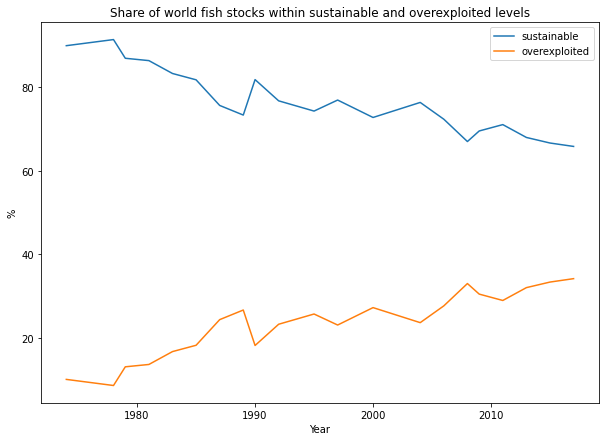

In [188]:
from operator import truediv

sus = sustainable_world['Share of fish stocks within biologically sustainable levels (FAO, 2020)'].tolist()
over = sustainable_world['Share of fish stocks that are overexploited'].tolist()
index = sustainable_world['Year']
df = pd.DataFrame({  'sustainable': sus,
    'overexploited': over}, index=index)
ax = df.plot.line(figsize=(10, 7))
ax.set_xlabel('Year')
ax.set_ylabel('%')
ax.set_title('Share of world fish stocks within sustainable and overexploited levels');

This was one of the first plots we made which clearly highlights the fact that we are on a rising trend of overfishing the oceans significantly

### Biggest culprits

# Data Analysis

### Import / Export comparison

In [189]:
import matplotlib.pyplot as plt
import numpy as np

In [190]:
fish_Im = pd.read_csv("data/FAOSTAT_import.csv")
fish_Ex = pd.read_csv("data/FAOSTAT_export.csv")

fish_Im = fish_Im.drop(
    ["Domain Code", "Domain", "Area Code (FAO)", "Element Code", "Element", "Item Code", "Item", "Year Code", "Unit", "Flag", "Flag Description"],
    axis=1);
# These are not present in export and not notable countries
fish_Im = fish_Im.loc[fish_Im["Area"] != "Tajikistan"];
fish_Im = fish_Im.loc[fish_Im["Area"] != "Afghanistan"];

fish_Ex = fish_Ex.drop(
    ["Domain Code", "Domain", "Area Code (FAO)", "Element Code", "Element", "Item Code", "Item", "Year Code", "Unit", "Flag", "Flag Description"],
    axis=1);

In [191]:
# Sort on highest import values
Im_lastyear = fish_Im.loc[fish_Im["Year"] == 2019].sort_values("Value", axis=0, ignore_index=True, ascending=False)
Ex_lastyear = fish_Ex.loc[fish_Ex["Year"] == 2019]

Ex_lastyear = Ex_lastyear.set_index('Area');
Ex_lastyear = Ex_lastyear.reindex(index=Im_lastyear["Area"]);
Ex_lastyear.reset_index();

Im_lastyear = Im_lastyear.set_index('Area');

In [192]:
# ALTERNATIVELY
# Sort on highest export values
Im_lastyear = fish_Im.loc[fish_Im["Year"] == 2019]
Ex_lastyear = fish_Ex.loc[fish_Ex["Year"] == 2019].sort_values("Value", axis=0, ignore_index=True, ascending=False)

Im_lastyear = Im_lastyear.set_index('Area');
Im_lastyear = Im_lastyear.reindex(index=Ex_lastyear["Area"]);
Im_lastyear.reset_index();

Ex_lastyear = Ex_lastyear.set_index('Area');

In [193]:
# show only the top N countries (set 178 for all)
N = 20
plt.rcParams['figure.figsize'] = [5, 5 + (N * 70 / 178)]
y_axis = Im_lastyear[0:N].index
x_axis_Im = Im_lastyear["Value"][0:N]
x_axis_Ex = Ex_lastyear["Value"][0:N]

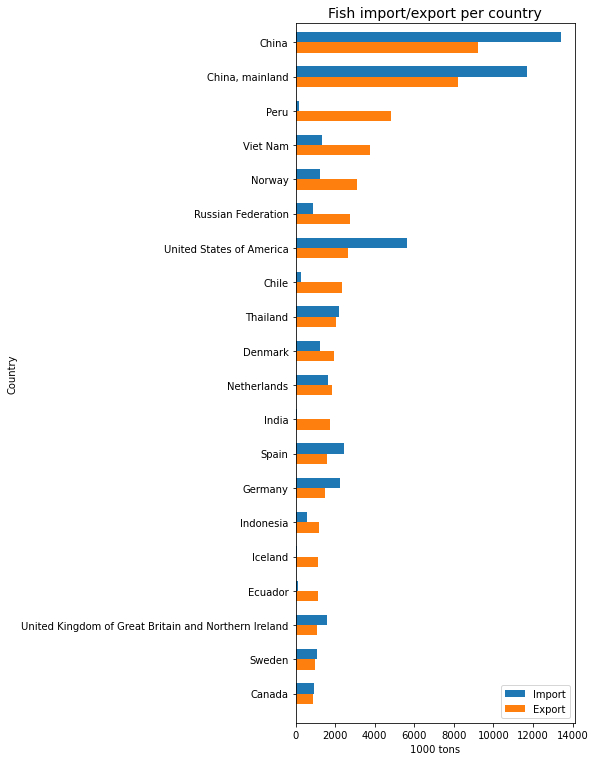

In [194]:
# Visualization
fig, ax = plt.subplots()

ind = np.arange(N)
width = 0.3

ax.barh(ind, x_axis_Im, width)  # IMPORT
ax.barh(ind + width, x_axis_Ex, width)  # EXPORT

ax.set(yticks=ind + width / 2, yticklabels=y_axis, ylim=[2 * width - 1, len(y_axis)])

plt.rcParams["legend.loc"] = 'lower right'
ax.legend(['Import', 'Export'])

plt.xlabel("1000 tons")
plt.ylabel("Country")
plt.title("Fish import/export per country", fontdict={'fontsize': 14})

# to show highest at the top
plt.gca().invert_yaxis()

plt.show()

In terms of impact it is evident that China is a significant contributor to the global import and export. Moreover, on 5th place we have the representative of the nordic region, Norway. Interestingly we find that Norway exports more than they import and vice versa for China.

### Capture fishery production

<AxesSubplot:xlabel='Year'>

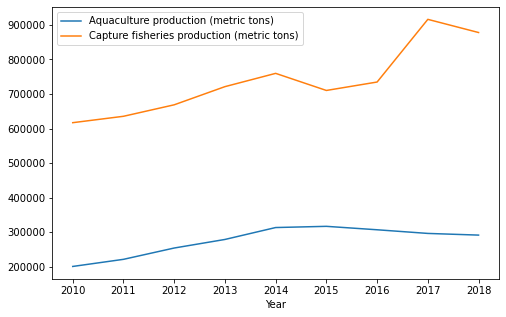

In [195]:
fish_prod = pd.read_csv('data/capture-fisheries-vs-aquaculture.csv')
fish_prod = fish_prod.set_index('Year')
fish_prod.query('Entity == "Nigeria" and Year >= 2010').plot(figsize=(8, 5))


In [196]:
fish_prod_lastyear = fish_prod.query('Year == 2017')
fish_prod_lastyear = fish_prod_lastyear.sort_values("Capture fisheries production (metric tons)", axis=0, ascending=False)
fish_prod_lastyear

,Entity,Code,Aquaculture production (metric tons),Capture fisheries production (metric tons)
Year,,,,
2017,IDA & IBRD total,NaN,1.041922e+08,71952300.38
2017,Low & middle income,NaN,1.035454e+08,68944889.73
2017,Middle income,NaN,1.027325e+08,66044865.73
2017,IBRD only,NaN,9.950129e+07,58935921.38
2017,East Asia & Pacific,NaN,9.373206e+07,40718597.78
...,...,...,...,...
2017,Gibraltar,GIB,NaN,1.00
2017,Liechtenstein,LIE,NaN,0.00
2017,San Marino,SMR,NaN,0.00


 Let's split them up next. Which can be done by checking for a country code. I though we might need `pip install pycountry`, but we don't.

In [197]:
fish_prod_lastyear_country = fish_prod_lastyear.loc[fish_prod_lastyear["Code"].notnull()]
fish_prod_lastyear_other = fish_prod_lastyear.loc[fish_prod_lastyear["Code"].isnull()]

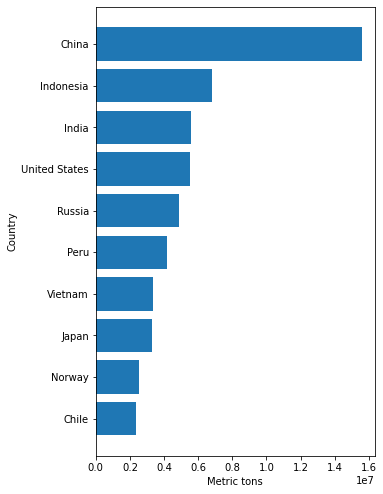

In [198]:
# show only the top N countries (set 215 for all)
N = 10

plt.rcParams['figure.figsize'] = [5, 5 + (N * 70 / 215)]

fig = plt.figure()

y_axis = fish_prod_lastyear_country["Entity"][0:N]
x_axis = fish_prod_lastyear_country["Capture fisheries production (metric tons)"][0:N]
plt.barh(y_axis, x_axis, height=0.8)

plt.xlabel("Metric tons")
plt.ylabel("Country")
plt.title("", fontdict={'fontsize': 14})

# to show highest at the top
plt.gca().invert_yaxis()

plt.show()

Again we see China as a major factor in production through capture fisheries. And yet again, the closest rival in the nordic and european region is Norway

## Global consumption trend

## GDP vs Consumption

After retrieving the mapping, we add the keys to the dataset. Some datasets have only country names but no codes, and others the otherway around. For the datasets with only country names, we had to manually map some of the country names to the equivalent name in the mapping dictionary. An example of such is seen below. We will comment the special cases but not more than once.

In [198]:
def get_industry_data():
    df = pd.read_csv('data/FAOSTAT_country_supply_production_import_export.csv')
    df.loc[df['Area'] == "China, mainland", 'Area'] = 'China'  # Generalize to China
    df.loc[df['Area'] == 'China, Hong Kong SAR', 'Area'] = 'China'
    df.loc[df['Area'] == 'China, Macao SAR', 'Area'] = 'China'
    df.loc[df['Area'] == "China, Taiwan Province of", 'Area'] = 'Taiwan'  # Taiwan on it's own
    df.loc[df['Area'] == "C?te d'Ivoire", 'Area'] = "Côte d'Ivoire"  # Special characters
    df.loc[df['Area'] == "Netherlands Antilles (former)", 'Area'] = "Netherlands"  # Longer names
    df.loc[df['Area'] == 'Bolivia (Plurinational State of)', 'Area'] = "Bolivia"  # No parenthesis
    df.loc[df['Area'] == 'Cabo Verde', 'Area'] = "Cape Verde"  # Different names for one country
    df.loc[df['Area'] == 'Czechia', 'Area'] = "Czech Republic"
    df.loc[df['Area'] == "Democratic People's Republic of Korea", 'Area'] = "South Korea"  # Common name rather than formal name
    df.loc[df['Area'] == 'Democratic Republic of the Congo', 'Area'] = "Congo"
    df.loc[df['Area'] == 'Eswatini', 'Area'] = "Swaziland"
    df.loc[df['Area'] == 'Iran (Islamic Republic of)', 'Area'] = "Iran, Islamic Republic of"
    df.loc[df['Area'] == 'North Macedonia', 'Area'] = "Macedonia, the former Yugoslav Republic of"
    df.loc[df['Area'] == 'Republic of Korea', 'Area'] = "Korea, Republic of"  # Reverse naming. Country name before title: country, title
    df.loc[df['Area'] == 'United Kingdom of Great Britain and Northern Ireland', 'Area'] = "United Kingdom"
    df.loc[df['Area'] == 'Republic of Moldova', 'Area'] = "Moldova, Republic of"
    df.loc[df['Area'] == 'United Republic of Tanzania', 'Area'] = "Tanzania, United Republic of"
    df.loc[df['Area'] == 'United States of America', 'Area'] = 'United States'
    df.loc[df['Area'] == 'Venezuela (Bolivarian Republic of)', 'Area'] = 'Venezuela, Bolivarian Republic of'

    # df = add_population(df)   # Out commented for explainer-notebook purposes
    return df

### Adding population data

After finding common keys across datasets, we add the population data for a given year which enables us to calculate any metric per capita: $metric\_per\_capita = \frac{metric}{population}$

In [198]:
def get_population():
    return pd.read_csv('data/population_total.csv')

In [199]:
def add_population(df, country_col='Area'):
    # Get data
    df_population = get_population()
    country_code_map, country_code_to_country = get_country_code_map()

    # Add the country code if it's not present in the dataframe
    if 'Country Code' not in df.columns:
        df['Country Code'] = df.apply(lambda x: country_code_map[x[country_col]]['Alpha-3 code'], axis=1)

    # Kind of advanced data wrangling operation, inspired from the Tidy data paradigm.
    # We give a brief introduction, but please look up the proper documentation if you don't understand the function.
    # Melting a dataframe is useful when we have a variable, such as 'Year' expanded over multiple columns.
    # For example the columns in a dataframe could be: [Country Name, Country Code, 2010, 2011, 2012, ... 2022]
    # Where each value in the 'Year' columns is a variable such as 'population'.
    # Melting the dataframe takes all the columns NAMES defined in 'value_vars' and assigns them to a single column
    # with the name: 'var_name' which in this case is 'Year'. Example var_name = pd.Series([2010, 2011, 2012, ..., 2022])
    # The corresponding value in that column is then assigned to another column in 'value_name'. The pairs of
    # [var_name, value_name] are then identical to what was previously in column format, however it is now only in row format.
    melted = pd.melt(df_population, id_vars=['Country Name', 'Country Code'], value_vars=df_population.columns[2:],
                     var_name='Year',
                     value_name='population')

    # Set year as integer to make them joinable
    melted.Year = melted.Year.astype(int)

    # Final merge operatoin
    df = pd.merge(melted, df, on=['Country Code', 'Year'])
    return df

After running the above function, there is a value of population for each country on each year.

In [200]:
df = get_industry_data()
add_population(df, country_col='Area').sample(4).iloc[:, :4]

### Data quality (NaN values and outliers)

#### Missing values
Missing values were investigated for all datasets. However, most of the datasets luckily did not show significant signs of poor quality in terms of NaN values.
In cases where there were NaN values, it was often in context of a visualization such as when plotting the consumption map. However, when plotting the map with NaN values,
it is a benefit as the countries are **kept out** of the map which is the same as dropping that particular row. If we would have imputed the value with for example: 0, it would've been manipulated data and perhaps lead to misinterpretations.

In [200]:
from plots.data import get_consumption

df = get_consumption()
df.drop('TotalC', axis=1, inplace=True)
df[df.isna().any(axis=1)].sample(5)

In [201]:
df[df.isna().any(axis=1)].country.unique().tolist()

It's seen that there are some countries that have missing country codes, but this is no issue for plotting. Moreover, we use the a custom _geojson_ to plot the maps, meaning that the regions such as (Africa, Americas, Asia, Europe, ...) will be left out as they aren't in the geojson.

In [202]:
import json

with open('data/countries-simplified.json') as response:
    countries = json.load(response)

countries['features'][0]['properties']

As you can see, we use the ISO_A3 (ISO Alpha 3) code to map countries and the geojson together. The ISO3 codes are in the consumption dataset, but _not_ in the industry dataset, which is why we add the country codes to it using the mapping. As without any country codes, we wouldn't be able to plot a choropleth map of the fishing industry

#### Outliers

Outliers didn't cause much trouble either. Except for one place when working with the scale of the colorbar in the consumption map. Let's take a look at the code. We WONT plot the map here as it takes up 150 Mb in the offline version.

In [202]:
from utils.decorator import style_plot
import plotly.express as px

@style_plot
def plot_consumption_map(df):
    with open('data/countries-simplified.json') as response:
        countries = json.load(response)

    # OUTLIERS!
    range_color = (0, df.consumption.quantile(0.99))
    # OUTLIERS!

    map_args = dict(
        geojson=countries,
        featureidkey='properties.ISO_A3',
        locations="Code",
        color="consumption",  # lifeExp is a column of gapminder
        hover_name="country",  # column to add to hover information
        animation_frame='Year',
        mapbox_style="carto-positron",
        color_continuous_scale='YlOrRd',
        range_color=range_color,
        title='Fish consumption (kg / capita) from 1961 to 2017',
        center={'lat': 12, 'lon': 5}
    )

    fig = px.choropleth_mapbox(df, zoom=0.5, **map_args)
    # More styling code below but it's been left out for brevity's sake.

As seen in line 10 of the cell above, we have adjusted the color of the range from 0 to 99% quantile. This is due to few extreme outliers that make identifying other high-consumption countries difficult. Let's take a look at the outliers.

In [39]:
df = get_consumption()

df.consumption.describe()

count    11028.000000
mean        16.670872
std         17.056281
min          0.000000
25%          5.340000
50%         11.995000
75%         22.512500
max        191.750000
Name: consumption, dtype: float64

The maximum value is 191 whilst the 75% quantile is only 22.5!! The data is clearly skewed.

<AxesSubplot:>

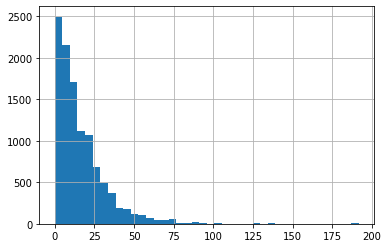

In [43]:
# Very simple plot for illustrative purposes.
df.consumption.hist(bins=40)

<AxesSubplot:>

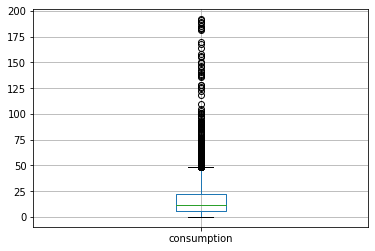

In [47]:
df.boxplot(column='consumption')

The 99% quantile is then

In [44]:
df.consumption.quantile(0.99)

75.34459999999999

Which is MUCH more reasonable when looking at the plots above as well.

**Industry dataset outliers**

We replicated the method above for the Industry dataset (import, export, production and supply) as well, however we don't find the need to replicate the whole process and analysis again (as it's copy paste with different a different dataset).
The resulting relevant quantile for the Industry dataset turned out to be 0.975 due to the same reasons above (extreme outliers).

**Other datasets**

With respect to the other datasets we didn't find any significant outliers that hindered the analysis or visualization.

## Dataset stats and key points

We have already touched upon the outlier and NaN value detection and corresponding mitigation techniques.

Here we will go over some key points of the exploratory analysis that lead us to the final visualizations found on the website.

### Overexploiting fish

In [73]:
sustainable = pd.read_csv('data/fish-stocks-within-sustainable-levels.csv')

In [74]:
sustainable_world = sustainable[sustainable["Entity"]=="World"]

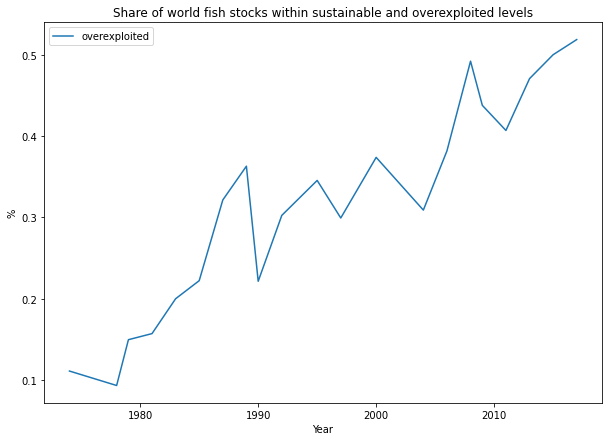

In [77]:
from operator import truediv

sus = sustainable_world['Share of fish stocks within biologically sustainable levels (FAO, 2020)'].tolist()
over = sustainable_world['Share of fish stocks that are overexploited'].tolist()
#sus = sus/sus
sus_map = list(map(truediv, sus, sus))
#over = over/sus
over_map = list(map(truediv, over, sus))

index = sustainable_world['Year']
df = pd.DataFrame({#'sustainable': sus_map,
                   'overexploited': over_map}, index=index)
ax = df.plot.line(figsize=(10,7))
ax.set_xlabel('Year')
ax.set_ylabel('%')
ax.set_title('Share of world fish stocks within sustainable and overexploited levels');

This was one of the first plots we made which clearly highlights the fact that we are on a rising trend of overfishing the oceans significantly

### Import / Export comparison

In [55]:
import matplotlib.pyplot as plt
import numpy as np

In [49]:
fish_Im = pd.read_csv("data/FAOSTAT_import.csv")
fish_Ex = pd.read_csv("data/FAOSTAT_export.csv")

fish_Im = fish_Im.drop(["Domain Code", "Domain", "Area Code (FAO)", "Element Code", "Element", "Item Code", "Item", "Year Code", "Unit", "Flag", "Flag Description"], axis=1);
# These are not present in export and not notable countries
fish_Im = fish_Im.loc[ fish_Im["Area"] != "Tajikistan" ];
fish_Im = fish_Im.loc[ fish_Im["Area"] != "Afghanistan" ];

fish_Ex = fish_Ex.drop(["Domain Code", "Domain", "Area Code (FAO)", "Element Code", "Element", "Item Code", "Item", "Year Code", "Unit", "Flag", "Flag Description"], axis=1);

In [50]:
# Sort on highest import values
Im_lastyear = fish_Im.loc[ fish_Im["Year"] == 2019 ].sort_values("Value", axis=0, ignore_index=True, ascending=False)
Ex_lastyear = fish_Ex.loc[ fish_Ex["Year"] == 2019 ]

Ex_lastyear = Ex_lastyear.set_index('Area');
Ex_lastyear = Ex_lastyear.reindex(index=Im_lastyear["Area"]);
Ex_lastyear.reset_index();

Im_lastyear = Im_lastyear.set_index('Area');

In [51]:
# ALTERNATIVELY
# Sort on highest export values
Im_lastyear = fish_Im.loc[ fish_Im["Year"] == 2019 ]
Ex_lastyear = fish_Ex.loc[ fish_Ex["Year"] == 2019 ].sort_values("Value", axis=0, ignore_index=True, ascending=False)

Im_lastyear = Im_lastyear.set_index('Area');
Im_lastyear = Im_lastyear.reindex(index=Ex_lastyear["Area"]);
Im_lastyear.reset_index();

Ex_lastyear = Ex_lastyear.set_index('Area');

In [54]:
# show only the top N countries (set 178 for all)
N = 20
plt.rcParams['figure.figsize'] = [5, 5 + (N*70/178)]
y_axis = Im_lastyear[0:N].index
x_axis_Im = Im_lastyear["Value"][0:N]
x_axis_Ex = Ex_lastyear["Value"][0:N]

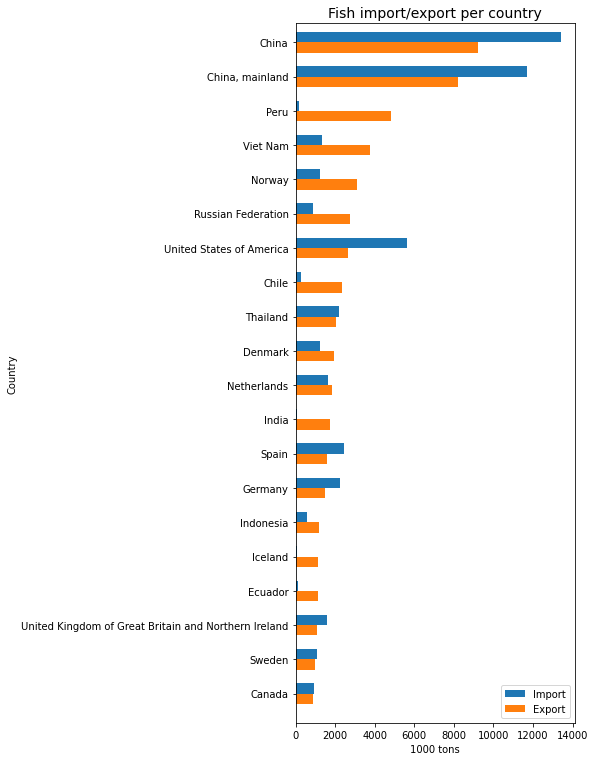

In [56]:
# Visualization
fig, ax = plt.subplots( )

ind = np.arange(N)
width = 0.3

ax.barh(ind, x_axis_Im, width) # IMPORT
ax.barh(ind + width, x_axis_Ex, width) # EXPORT

ax.set(yticks=ind + width/2, yticklabels=y_axis, ylim=[2*width - 1, len(y_axis)])

plt.rcParams["legend.loc"] = 'lower right'
ax.legend(['Import', 'Export'])

plt.xlabel( "1000 tons" )
plt.ylabel( "Country" )
plt.title( "Fish import/export per country" , fontdict = {'fontsize': 14} )

# to show highest at the top
plt.gca().invert_yaxis()

plt.show()

In terms of impact it is evident that China is a significant contributor to the global import and export. Moreover, on 5th place we have the representative of the nordic region, Norway. Interestingly we find that Norway exports more than they import and vice versa for China.

### Capture fishery production

<AxesSubplot:xlabel='Year'>

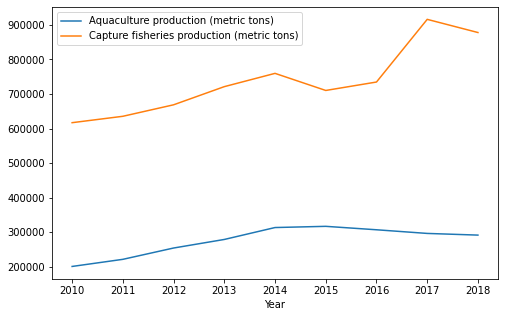

In [61]:
fish_prod = pd.read_csv('data/capture-fisheries-vs-aquaculture.csv')
fish_prod = fish_prod.set_index('Year')
fish_prod.query('Entity == "Nigeria" and Year >= 2010').plot(figsize=(8,5))


In [68]:
fish_prod_lastyear = fish_prod.query('Year == 2017')
fish_prod_lastyear = fish_prod_lastyear.sort_values("Capture fisheries production (metric tons)", axis=0, ascending=False)
fish_prod_lastyear

,Entity,Code,Aquaculture production (metric tons),Capture fisheries production (metric tons)
Year,,,,
2017,IDA & IBRD total,NaN,1.041922e+08,71952300.38
2017,Low & middle income,NaN,1.035454e+08,68944889.73
2017,Middle income,NaN,1.027325e+08,66044865.73
2017,IBRD only,NaN,9.950129e+07,58935921.38
2017,East Asia & Pacific,NaN,9.373206e+07,40718597.78
...,...,...,...,...
2017,Gibraltar,GIB,NaN,1.00
2017,Liechtenstein,LIE,NaN,0.00
2017,San Marino,SMR,NaN,0.00


 Let's split them up next. Which can be done by checking for a country code. I though we might need `pip install pycountry`, but we don't.

In [71]:
fish_prod_lastyear_country = fish_prod_lastyear.loc[ fish_prod_lastyear["Code"].notnull() ]
fish_prod_lastyear_other = fish_prod_lastyear.loc[ fish_prod_lastyear["Code"].isnull() ]

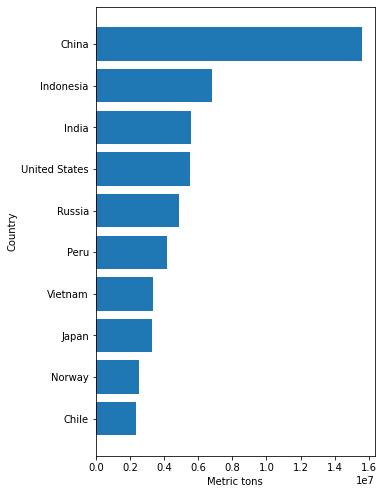

In [72]:
# show only the top N countries (set 215 for all)
N = 10

plt.rcParams['figure.figsize'] = [5, 5 + (N*70/215)]

fig = plt.figure( )

y_axis = fish_prod_lastyear_country["Entity"][0:N]
x_axis = fish_prod_lastyear_country["Capture fisheries production (metric tons)"][0:N]
plt.barh(y_axis, x_axis, height=0.8)


plt.xlabel( "Metric tons" )
plt.ylabel( "Country" )
plt.title( "" , fontdict = {'fontsize': 14} )

# to show highest at the top
plt.gca().invert_yaxis()

plt.show()

Again we see China as a major factor in production through capture fisheries. And yet again, the closest rival in the nordic and european region is Norway

# Data Analysis

# Genre

## Which genre

## Visual Narrative

## Narrative Structure

# Visualizations

# Website

# Discussion

# Contributions